In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

C:\Users\rahul\Anaconda3_New\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# %matplotlib inline
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
# warnings.filterwarnings("ignore")

In [3]:
test = pd.read_csv("../data/test.csv")
shops = pd.read_csv("../data/shops.csv")
items = pd.read_csv("../data/items.csv")
item_categories = pd.read_csv("../data/item_categories.csv")
test = pd.read_csv("../data/test.csv")
sample_submission = pd.read_csv("../data/sample_submission.csv")
sales = pd.read_csv("../data/sales_train.csv")

In [4]:
# sales = pd.read_csv("data/sales_train.csv", parse_dates=['date'], 
#                     dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
#                            'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [5]:
#Taking a join across items, shops and item categories
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [6]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


In [7]:
print('Train rows: ', train.shape[0])
print('Train columns: ', train.shape[1])

Train rows:  2935849
Train columns:  10


In [8]:
train.head().T

,0,1,2,3,4
date,02.01.2013,03.01.2013,05.01.2013,06.01.2013,15.01.2013
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999,899,899,1709.05,1099
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


In [9]:
print (min(train['date']))

print (max(train['date']))

01.01.2013
31.12.2014


In [10]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
train = train[train['item_id'].isin(test_item_ids)]

In [11]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
10,03.01.2013,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
11,05.01.2013,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
12,07.01.2013,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
13,08.01.2013,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства


In [12]:
train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_cnt_day':['sum']})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20')

# Label
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)
train_monthly.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
date_block_num,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
shop_id,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
item_id,33.0,482.0,491.0,839.0,1007.0,1010.0,1023.0,1204.0,1224.0,1247.0,1409.0,1467.0,1523.0,1829.0,1905.0,1916.0,2252.0,2308.0,2416.0,2678.0
item_cnt,1.0,1.0,1.0,1.0,3.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,6.0,4.0,3.0,3.0,1.0,3.0,1.0,1.0
item_cnt_month,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,2.0,2.0,2.0,2.0,1.0,4.0,1.0,2.0


In [13]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,593829.0,20.183908,9.138399,0.0,13.0,22.0,28.0,33.0
shop_id,593829.0,32.072593,16.901044,2.0,19.0,31.0,47.0,59.0
item_id,593829.0,10015.023249,6181.818768,30.0,4418.0,9171.0,15334.0,22167.0
item_cnt,593829.0,2.097798,2.305983,0.0,1.0,1.0,2.0,20.0
item_cnt_month,482536.0,2.067239,2.165632,0.0,1.0,1.0,2.0,20.0


In [14]:
#Replace missing vals with 0
monthly_series = train_monthly.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num',values='item_cnt', fill_value=0).reset_index()

In [15]:
monthly_series.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,30,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,31,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,32,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,2,33,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0
4,2,53,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [16]:
# We have one series (33months) for each unique pair of shop_id and item_id. 
#Generating smaller series for each unique pair, hence multiple series of size 12 (one year) for each pair.

serie_size = 12
data_series = []
first_month = 20
last_month = 33

for index, row in monthly_series.iterrows():
    for month1 in range((last_month - (first_month + serie_size)) + 1):
        serie = [row['shop_id'], row['item_id']]
        for month2 in range(serie_size + 1):
            serie.append(row[month1 + first_month + month2])
        data_series.append(serie)

columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(serie_size)]
columns.append('label')

data_series = pd.DataFrame(data_series, columns=columns)
data_series.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,label
0,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,31,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,31,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2,32,2,2,0,2,0,0,1,0,0,0,0,1,0


In [17]:
data_series = data_series.drop(['item_id', 'shop_id'], axis=1)
data_series.head()

,0,1,2,3,4,5,6,7,8,9,10,11,label
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2,2,0,2,0,0,1,0,0,0,0,1,0


In [18]:
labels = data_series['label']
data_series.drop('label', axis=1, inplace=True)
train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.20, random_state=0)

In [19]:
print("Train set", train.shape)
print("Validation set", valid.shape)
train.head()

Train set (178068, 12)
Validation set (44518, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
98822,2,1,0,4,1,1,1,0,0,0,0,0
65534,0,0,0,0,0,0,0,0,0,0,0,0
141282,0,0,0,0,1,0,0,0,0,1,1,0
72455,0,0,0,0,0,0,0,0,1,0,0,0
203819,0,0,0,0,0,0,0,1,3,0,1,0


In [20]:
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))

print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)

Train set reshaped (178068, 12, 1)
Validation set reshaped (44518, 12, 1)


In [21]:
serie_size =  X_train.shape[1] # 12
n_features =  X_train.shape[2] # 1

print (serie_size)

print (n_features)

epochs = 10
batch = 128
lr = 0.0001

12
1


### LSTM Autoencoder

In [22]:
encoder_decoder = Sequential()
encoder_decoder.add(LSTM(serie_size, activation='relu', input_shape=(serie_size, n_features), return_sequences=True))
encoder_decoder.add(LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(LSTM(1, activation='relu'))
encoder_decoder.add(RepeatVector(serie_size))
encoder_decoder.add(LSTM(serie_size, activation='relu', return_sequences=True))
encoder_decoder.add(LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(TimeDistributed(Dense(1)))
encoder_decoder.summary()

adam = optimizers.Adam(lr)
encoder_decoder.compile(loss='mse', optimizer=adam)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 12)            672       
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 6)             456       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1)                 32        
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 12, 1)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 12)            672       
_________________________________________________________________
lstm_5 (LSTM)                (None, 12, 6)             456       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 1)            

In [23]:
encoder_decoder_history = encoder_decoder.fit(X_train, X_train, epochs=epochs, batch_size=batch, verbose=2)

Epoch 1/10
 - 37s - loss: 1.3973
Epoch 2/10
 - 36s - loss: 1.1255
Epoch 3/10
 - 39s - loss: 1.0791
Epoch 4/10
 - 41s - loss: 1.0473
Epoch 5/10
 - 37s - loss: 1.0297
Epoch 6/10
 - 35s - loss: 1.0180
Epoch 7/10
 - 37s - loss: 1.0119
Epoch 8/10
 - 37s - loss: 1.0036
Epoch 9/10
 - 40s - loss: 0.9948
Epoch 10/10
 - 38s - loss: 0.9912


#### Encoder model

In [24]:
encoder = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[2].output)

In [25]:
train_encoded = encoder.predict(X_train)
validation_encoded = encoder.predict(X_valid)

In [26]:
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

Encoded time-series shape (178068, 1)
Encoded time-series sample [0.45485184]


#### LSTM encoded feature

In [27]:
train['encoded'] = train_encoded
train['label'] = Y_train

valid['encoded'] = validation_encoded
valid['label'] = Y_valid

C:\Users\rahul\Anaconda3_New\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\rahul\Anaconda3_New\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\rahul\Anaconda3_New\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [28]:
train.head(15)

,0,1,2,3,4,5,6,7,8,9,10,11,encoded,label
98822,2,1,0,4,1,1,1,0,0,0,0,0,4.548518e-01,0
65534,0,0,0,0,0,0,0,0,0,0,0,0,2.748231e-07,0
141282,0,0,0,0,1,0,0,0,0,1,1,0,2.406906e-01,0
72455,0,0,0,0,0,0,0,0,1,0,0,0,5.530577e-02,1
203819,0,0,0,0,0,0,0,1,3,0,1,0,7.256173e-01,2
218547,5,17,12,17,5,10,3,6,3,4,5,4,6.202526e+01,7
74652,1,1,0,1,0,9,0,0,0,0,0,5,3.652729e+00,2
66605,1,1,0,0,0,0,0,0,0,0,0,0,8.377308e-08,0
212835,0,1,0,0,0,0,0,1,0,0,0,0,6.624532e-02,0
150547,0,2,0,0,0,0,0,0,0,0,0,0,6.315644e-09,0


In [29]:
last_month = serie_size - 1
Y_train_encoded = train['label']
train.drop('label', axis=1, inplace=True)
X_train_encoded = train[[last_month, 'encoded']]

Y_valid_encoded = valid['label']
valid.drop('label', axis=1, inplace=True)
X_valid_encoded = valid[[last_month, 'encoded']]

print("Train set", X_train_encoded.shape)
print("Validation set", X_valid_encoded.shape)

C:\Users\rahul\Anaconda3_New\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Train set (178068, 2)
Validation set (44518, 2)


In [30]:
multilayer_model = Sequential()
multilayer_model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu', input_dim=X_train_encoded.shape[1]))
multilayer_model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
multilayer_model.add(Dense(1))
multilayer_model.summary()

adam = optimizers.Adam(lr)

multilayer_model.compile(loss='mse', optimizer=adam, metrics = ['mean_squared_error'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [31]:
mlp_history = multilayer_model.fit(X_train_encoded.values, Y_train_encoded.values, epochs=30, batch_size=batch, validation_data=(X_valid_encoded, Y_valid_encoded), verbose=2)

Train on 178068 samples, validate on 44518 samples
Epoch 1/30
 - 2s - loss: 1.5344 - mean_squared_error: 1.5344 - val_loss: 1.2262 - val_mean_squared_error: 1.2262
Epoch 2/30
 - 1s - loss: 1.2643 - mean_squared_error: 1.2643 - val_loss: 1.1920 - val_mean_squared_error: 1.1920
Epoch 3/30
 - 2s - loss: 1.2465 - mean_squared_error: 1.2465 - val_loss: 1.1857 - val_mean_squared_error: 1.1857
Epoch 4/30
 - 2s - loss: 1.2432 - mean_squared_error: 1.2432 - val_loss: 1.1863 - val_mean_squared_error: 1.1863
Epoch 5/30
 - 2s - loss: 1.2423 - mean_squared_error: 1.2423 - val_loss: 1.1838 - val_mean_squared_error: 1.1838
Epoch 6/30
 - 1s - loss: 1.2412 - mean_squared_error: 1.2412 - val_loss: 1.1829 - val_mean_squared_error: 1.1829
Epoch 7/30
 - 2s - loss: 1.2413 - mean_squared_error: 1.2413 - val_loss: 1.1842 - val_mean_squared_error: 1.1842
Epoch 8/30
 - 1s - loss: 1.2405 - mean_squared_error: 1.2405 - val_loss: 1.1828 - val_mean_squared_error: 1.1828
Epoch 9/30
 - 2s - loss: 1.2404 - mean_square

Text(0,0.5,'MSE')

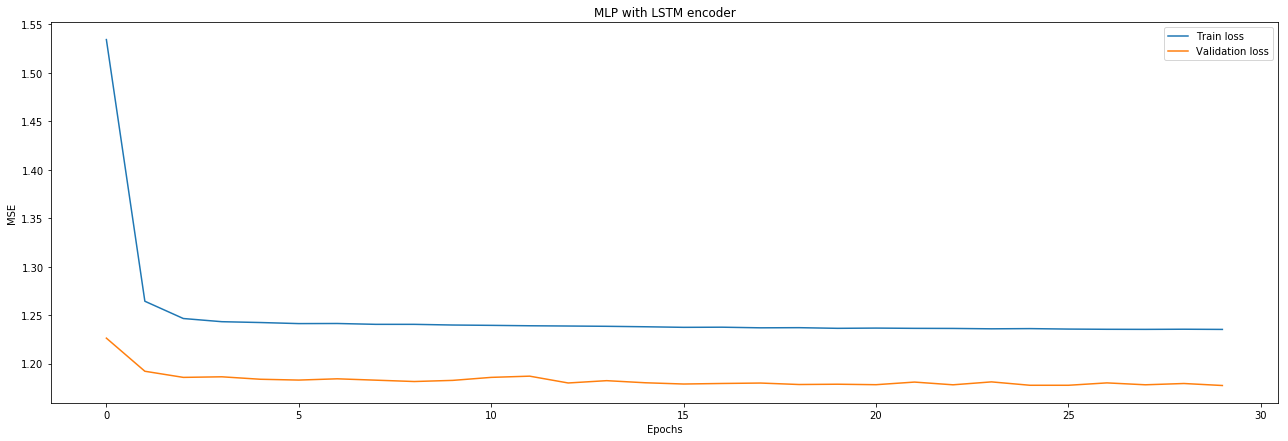

In [32]:
fig, (ax2) = plt.subplots(1, 1, sharey=False,figsize=(22,7))

ax2.plot(mlp_history.history['loss'], label='Train loss')
ax2.plot(mlp_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('MLP with LSTM encoder')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')